In [1]:
#VADER = body_sentiment
#TextBlob = blob_sent

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pmaw import PushshiftAPI
import matplotlib.pyplot as plt
import math
from datetime import datetime
import datetime as dt
from nltk.tokenize import RegexpTokenizer, TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix
import re
import string
import seaborn as sns
from wordcloud import WordCloud

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
pd.set_option('display.max_colwidth', -1)

<ipython-input-2-4d7cd63834e5>:31: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [3]:
df = pd.read_csv('data/amc_modeling.csv', low_memory=False)

In [4]:
df.dropna(inplace=True)
df.isna().sum()

body                     0
score                    0
total_awards_received    0
created_utc              0
author                   0
permalink                0
cleaned_body             0
body_sentiment           0
blob_sent                0
dtype: int64

In [5]:
X = df['cleaned_body']
y = df['body_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
stopwords_list = stopwords.words('english')
vectorizer = CountVectorizer(stop_words=stopwords_list, max_features=200)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [7]:
# tfidf = TfidfVectorizer(stop_words=stopwords_list, max_features=200)
# X_train_vectorized = tfidf.fit_transform(X_train)
# X_test_vectorized = tfidf.transform(X_test)

In [8]:
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=vectorizer.get_feature_names())

,10,100,20,30,50,actually,ago,already,also,always,...,went,wish,worth,would,wsb,yeah,year,years,yes,youre
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74911,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Categorical Classification

### First Simple Model: NaiveBayes

In [9]:
baseline_model = MultinomialNB()
baseline_model.fit(X_train_vectorized, y_train)
baseline_model.score(X_train_vectorized, y_train)

0.6643172747053249

In [10]:
y_pred_bm = baseline_model.predict(X_test_vectorized)
print(accuracy_score(y_test, y_pred_bm))

0.6680682364247957


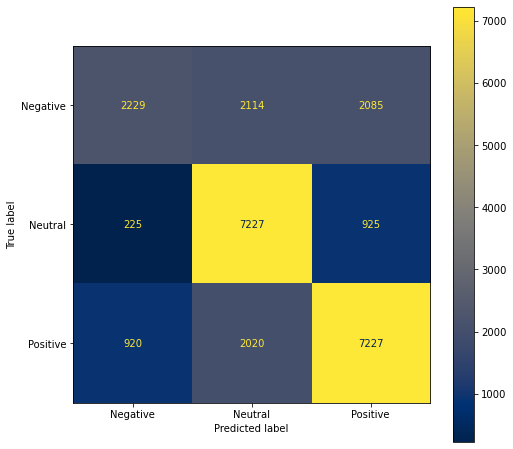

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(baseline_model, X_test_vectorized, y_test, ax=ax, cmap="cividis");

### RandomForest

In [12]:
rf = RandomForestClassifier()
rf.fit(X_train_vectorized, y_train)
rf.score(X_train_vectorized, y_train)

0.9038484642184934

In [13]:
y_pred_rf = rf.predict(X_test_vectorized)
print(accuracy_score(y_test, y_pred_rf))

0.6565753644081371


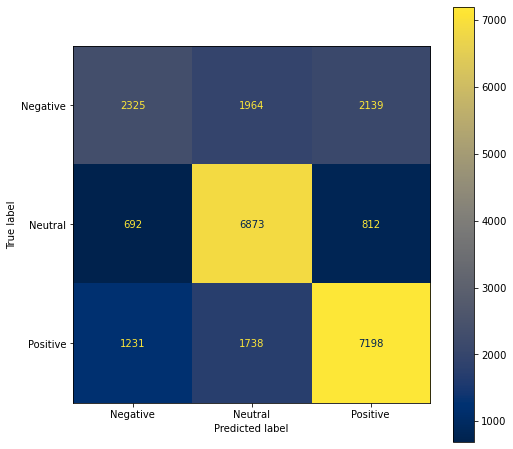

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(rf, X_test_vectorized, y_test, ax=ax, cmap="cividis");

### DecisionTree

In [15]:
dt = DecisionTreeClassifier()
dt.fit(X_train_vectorized, y_train)
dt.score(X_train_vectorized, y_train)

0.9038484642184934

In [16]:
y_pred_dt = dt.predict(X_test_vectorized)
y_pred_dt = dt.predict(X_test_vectorized)
print(accuracy_score(y_test, y_pred_dt))

0.6148886753163543


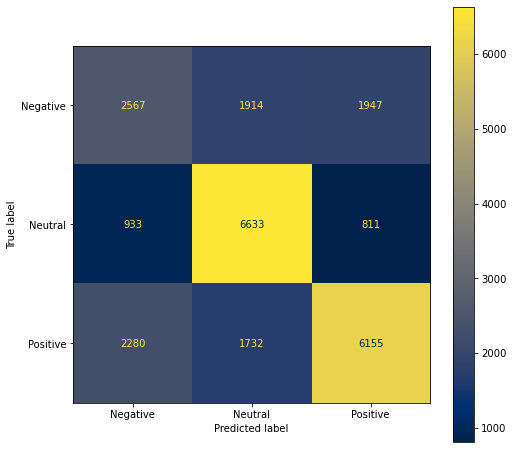

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(dt, X_test_vectorized, y_test, ax=ax, cmap="cividis");

### XGBoost

In [18]:
from xgboost import XGBClassifier

In [19]:
xgb = XGBClassifier(eval_metric='mlogloss')
xgb.fit(X_train_vectorized, y_train)
xgb.score(X_train_vectorized, y_train)

C:\Users\dougl\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7187804519909762

In [20]:
y_pred_xgb = xgb.predict(X_test_vectorized)
print(accuracy_score(y_test, y_pred_xgb))

0.6854076565753644


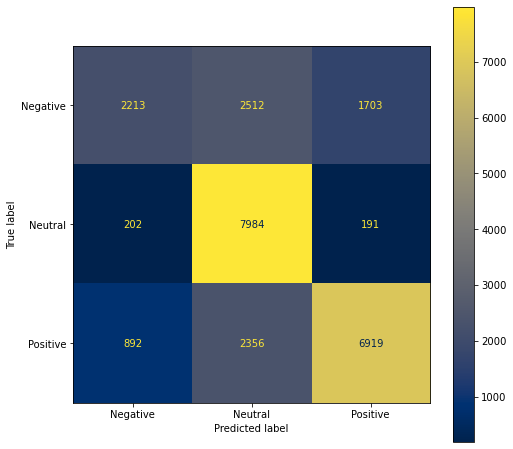

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(xgb, X_test_vectorized, y_test, ax=ax, cmap="cividis");

The XGBoost did the best with a .72 training score and .69 test score. The naive bayes was middle of the road. The training and test scores were similar at .66. The decision tree and random forest had massive overfitting resulting in much lower test scores than training scores. 

### Verifying the accuracy of the body_sentiment column by manual labeling

Create a random sample of 100 entries. Manually label the comments either positive, neutral, or negative. Verify the accuracy of body_sentiment generated by VADER. 
Create a new column called blob_sent generated by another lexicon sentiment analyzer, TextBlob (SentiWordNet). Verify the accuracy of blob_sent.
The distribution according to VADER was Positive 40%, Neutral 34%, Negative 26%. The distribution according to TextBlob was Neutral 39%, Positive 37%, Negative 24%.

In [22]:
sample_df = df.sample(n=100, random_state=42)

In [23]:
# sample_df.iloc[90:100]['body']

In [24]:
labels = ['Positive','Positive','Negative','Negative','Positive','Negative','Positive','Positive','Neutral','Neutral',
         'Negative','Neutral','Positive','Positive','Neutral','Positive','Negative','Positive','Neutral','Positive',
          'Positive','Positive','Neutral','Positive','Neutral','Negative','Positive','Positive','Positive','Negative',
          'Negative','Positive','Positive','Neutral','Negative','Positive','Negative','Positive','Positive','Positive',
          'Positive','Positive','Positive','Neutral','Positive','Negative','Negative','Neutral','Neutral','Negative',
          'Neutral','Positive','Positive','Neutral','Positive','Positive','Neutral','Positive','Negative','Positive',
          'Negative','Neutral','Negative','Neutral','Positive','Negative','Positive','Neutral','Negative','Positive',
          'Negative','Negative','Positive','Positive','Neutral','Neutral','Positive','Positive','Negative','Neutral',
          'Positive','Negative','Positive','Neutral','Positive','Negative','Neutral','Neutral','Negative','Positive',
          'Positive','Neutral','Positive','Neutral','Positive','Positive','Positive','Positive','Neutral','Positive'
         ]

In [25]:
sample_df = sample_df[['body','cleaned_body','body_sentiment','blob_sent']]

In [26]:
sample_df['labels']=labels

In [27]:
accuracy_score(sample_df['labels'],sample_df['body_sentiment'])

0.43

In [28]:
accuracy_score(sample_df['labels'],sample_df['blob_sent'])

0.42

*SOOO it turns out that VADER is only returning a 43% accuracy score on it's rule based sentiment classifications as compared to my manually labeled column. When I performed the accuracy score on TextBlob sentiment classifications against the manually labeled column, it turned out to be very similar at 42% accuracy. It may be due to the subjective nature of posts in relation to the stock market and price, as well as the amount of noise present within reddit and social media environments in general.
<br><br>
Lets try quantitative analysis of the sentiment scores in the next section and how these scores changed over time. We will import the time series data we prepared in the EDA.*

# Time Series (numerical classification)

In [48]:
ts = pd.read_csv('data/amc_numeric_sents.csv', low_memory=False)
ts.head()

,cleaned_body,created_utc,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Compound Sentiment
0,same i love movies and some movies really have to be seen in the theater to really appreciate them when this is all over im definitely hitting up amc to watch some flicks with a beer and tendies,1614904519,0.231001,0.769001,0.000001,0.871801
1,i have a question for anyone that has the answer to this are the hedgefunds that shorted gme the same hedgefunds that shorted amc why are these two so similar in price action,1614904484,0.000001,1.000001,0.000001,0.000001
2,hey guys on a scale of 110 how retarded am i i bought 7 puts on amc while it was tanking while 50 of everything ive earned is in it 9,1614904447,0.000001,0.871001,0.129001,-0.571899
3,got 50 amc at 1330 and 52 gme at 111 don’t forget me on the way,1614904423,0.000001,0.888001,0.112001,-0.226299
4,truly fuck amc,1614904404,0.392001,0.135001,0.473001,-0.153099


In [49]:
def unix_to_date(input):
    ts = int(input)
    print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

In [52]:
date = []
for i in ts['created_utc']:
    x = int(i)
    date.append(datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
ts['date']=date

In [53]:
ts['date'] = pd.to_datetime(ts['date'])
ts.set_index('date',inplace=True)

In [55]:
ts.drop(['cleaned_body','created_utc','Neutral Sentiment','Negative Sentiment','Compound Sentiment'],axis=1,inplace=True)

In [124]:
ts_d = ts.resample('D').mean()

In [126]:
ts_d = ts_d.interpolate()
ts_d.isna().sum()

Positive Sentiment    0
dtype: int64

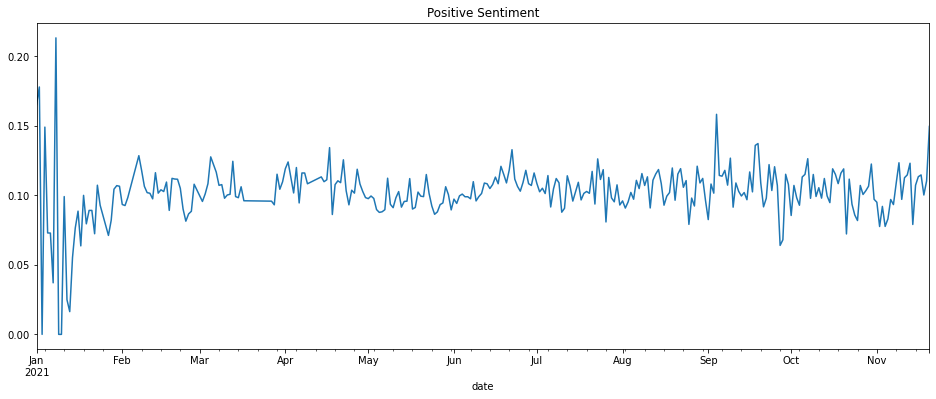

In [157]:
plt.figure(figsize=(16,6))
ts_d['Positive Sentiment'].plot()
plt.title('Positive Sentiment');

In [106]:
#originally 10 NaNs in march
# ts_daily[(ts_daily.index > '2021-03-01')&(ts_daily.index < '2021-04-01')] 

In [110]:
ts_w = ts.resample('W').mean()

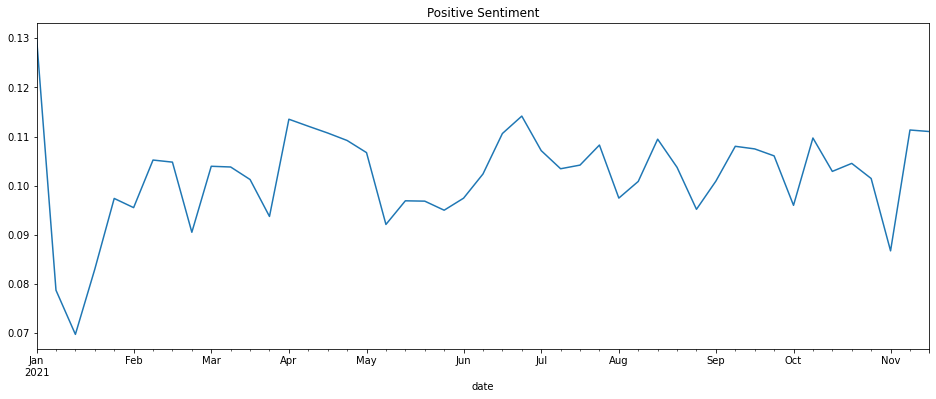

In [111]:
plt.figure(figsize=(16,6))
ts_w['Positive Sentiment'].plot()
plt.title('Positive Sentiment')
plt.show()

In [112]:
ts_m = ts.resample('M').mean()

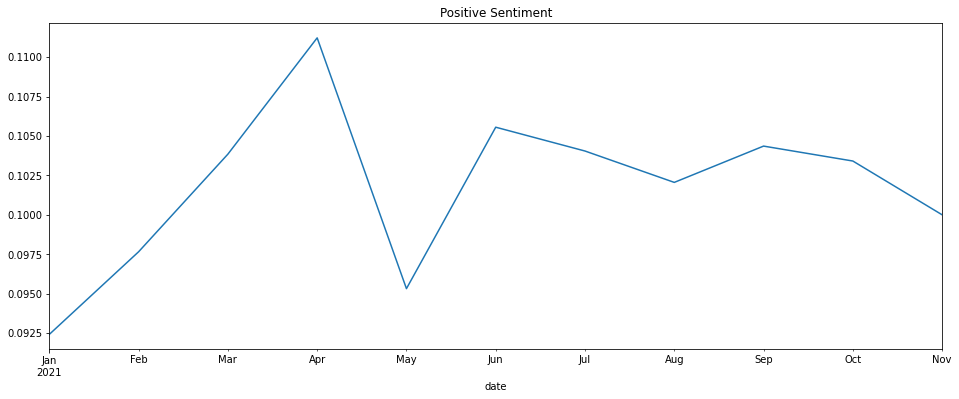

In [113]:
plt.figure(figsize=(16,6))
ts_m['Positive Sentiment'].plot()
plt.title('Positive Sentiment')
plt.show()

In [128]:
roll_mean_d = ts_d['Positive Sentiment'].rolling(window=7, center=False).mean()
roll_std_d = ts_d['Positive Sentiment'].rolling(window=7, center=False).std()

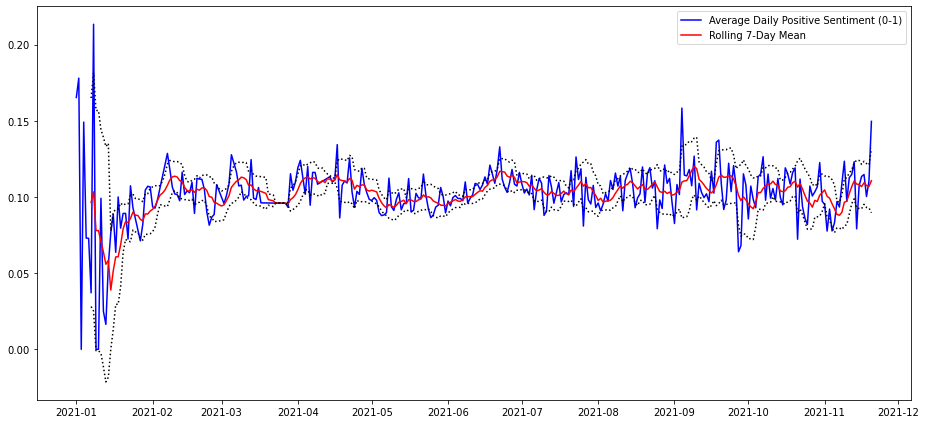

In [129]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(ts_d['Positive Sentiment'], color='blue',
        label='Average Daily Positive Sentiment (0-1)')

ax.plot(roll_mean_d, color='red', label='Rolling 7-Day Mean')

ax.plot(roll_mean_d + roll_std_d, color='black', linestyle='dotted')
ax.plot(roll_mean_d - roll_std_d, color='black', linestyle='dotted')

ax.legend()
fig.tight_layout()

In [117]:
roll_mean_w = ts_w['Positive Sentiment'].rolling(window=4, center=False).mean()
roll_std_w = ts_w['Positive Sentiment'].rolling(window=4, center=False).std()

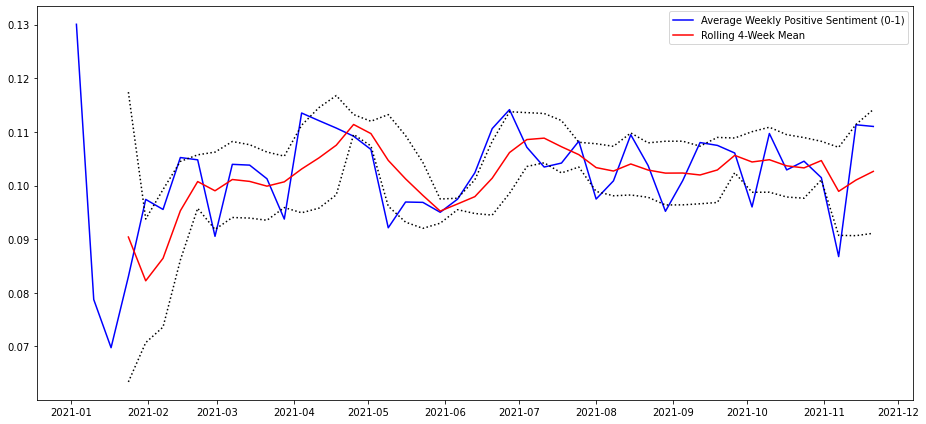

In [130]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(ts_w['Positive Sentiment'], color='blue',
        label='Average Weekly Positive Sentiment (0-1)')

ax.plot(roll_mean_w, color='red', label='Rolling 4-Week Mean')

ax.plot(roll_mean_w + roll_std_w, color='black', linestyle='dotted')
ax.plot(roll_mean_w - roll_std_w, color='black', linestyle='dotted')

ax.legend()
fig.tight_layout()

In [132]:
adfuller(ts_d['Positive Sentiment'])

(-4.265132532797217,
 0.00051019421656941,
 7,
 316,
 {'1%': -3.4512146067362317,
  '5%': -2.870730188960711,
  '10%': -2.5716664849383113},
 -1843.7621550895592)

In [133]:
adfuller(ts_w['Positive Sentiment'])

(-5.597991362722379,
 1.2839057729102833e-06,
 0,
 46,
 {'1%': -3.5812576580093696,
  '5%': -2.9267849124681518,
  '10%': -2.6015409829867675},
 -256.4439289395507)

Both the daily and weekly positive sentiments meet the criteria for stationarity according to the dicky fuller test.

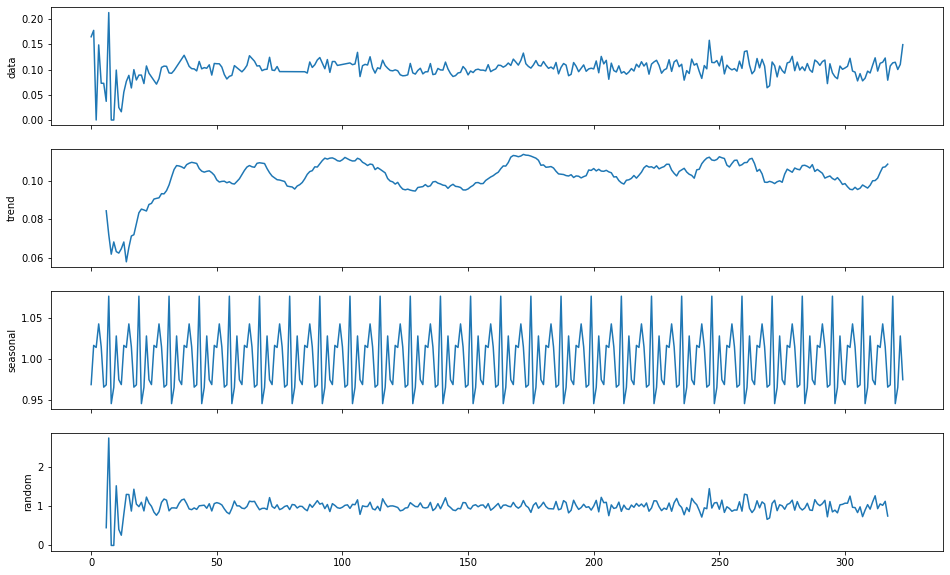

In [137]:
decomposed_d = decompose(ts_d['Positive Sentiment'].values, 'multiplicative', m=12)
decomposed_plot(decomposed_d, figure_kwargs={'figsize': (16, 10)})
plt.show()

In [158]:
# decomposed_w = decompose(ts_w['Positive Sentiment'].values, 'multiplicative', m=12)
# decomposed_plot(decomposed_w, figure_kwargs={'figsize': (16, 10)})
# plt.show()

In [141]:
comp_ts = pd.read_csv('data/amc_numeric_sents.csv', low_memory=False)

In [142]:
date = []
for i in comp_ts['created_utc']:
    x = int(i)
    date.append(datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
comp_ts['date']=date

In [145]:
comp_ts['date'] = pd.to_datetime(comp_ts['date'])
comp_ts.set_index('date', inplace=True)

In [148]:
comp_ts.drop(['cleaned_body','created_utc','Positive Sentiment','Neutral Sentiment','Negative Sentiment'],axis=1,inplace=True)

In [155]:
comp_ts_d = comp_ts.resample('D').mean()
comp_ts_d = comp_ts_d.interpolate()

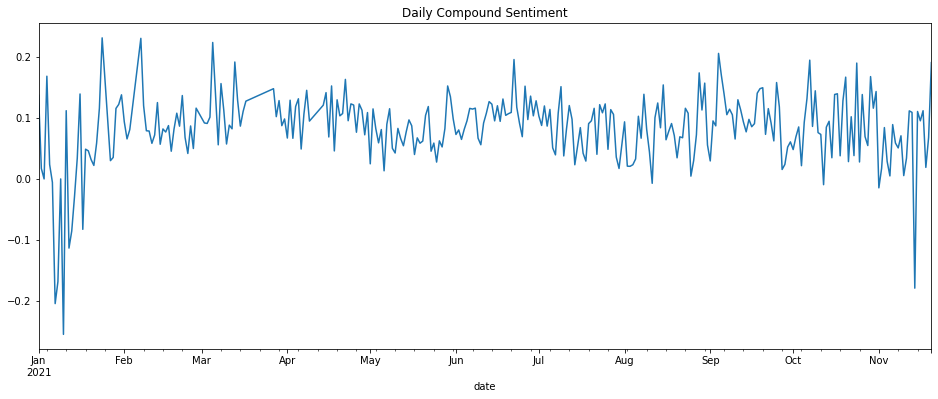

In [164]:
plt.figure(figsize=(16,6))
comp_ts_d['Compound Sentiment'].plot()
plt.title('Daily Compound Sentiment');

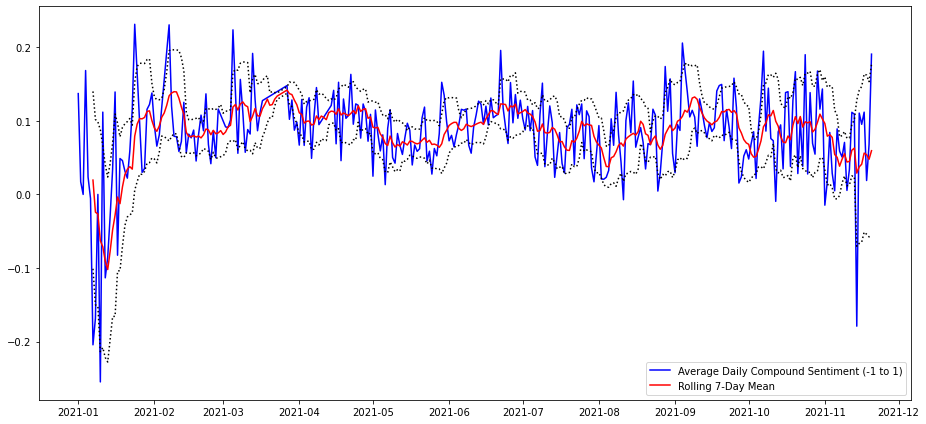

In [163]:
rollmean_comp_d = comp_ts_d['Compound Sentiment'].rolling(window=7, center=False).mean()
rollstd_comp_d = comp_ts_d['Compound Sentiment'].rolling(window=7, center=False).std()
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(comp_ts_d['Compound Sentiment'], color='blue',
        label='Average Daily Compound Sentiment (-1 to 1)')

ax.plot(rollmean_comp_d, color='red', label='Rolling 7-Day Mean')

ax.plot(rollmean_comp_d + rollstd_comp_d, color='black', linestyle='dotted')
ax.plot(rollmean_comp_d - rollstd_comp_d, color='black', linestyle='dotted')

ax.legend()
fig.tight_layout()

In [167]:
adfuller(comp_ts_d['Compound Sentiment'])

(-4.825611112981673,
 4.857158484330318e-05,
 15,
 308,
 {'1%': -3.45176116018037,
  '5%': -2.870970093607691,
  '10%': -2.571794416006072},
 -1027.0985548351796)

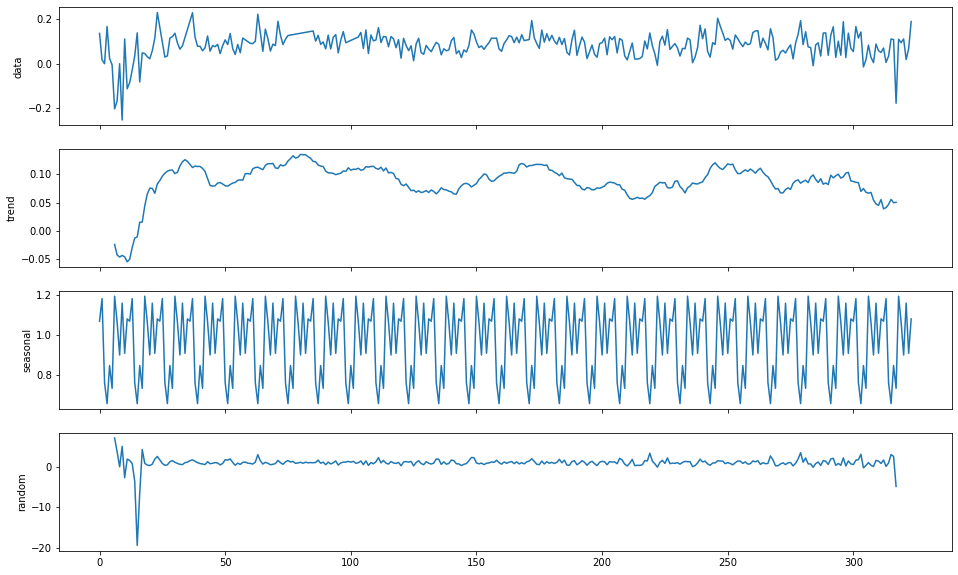

In [168]:
decomposed_comp_d = decompose(comp_ts_d['Compound Sentiment'].values, 'multiplicative', m=12)
decomposed_plot(decomposed_comp_d, figure_kwargs={'figsize': (16, 10)});

### Random Walk model

In [170]:
#https://github.com/Amberlynnyandow/bsc-lecture-material/blob/main/phase_4/time_series_modeling.ipynb

In [169]:
cutoff = round(comp_ts_d.shape[0]*0.8)
cutoff

259

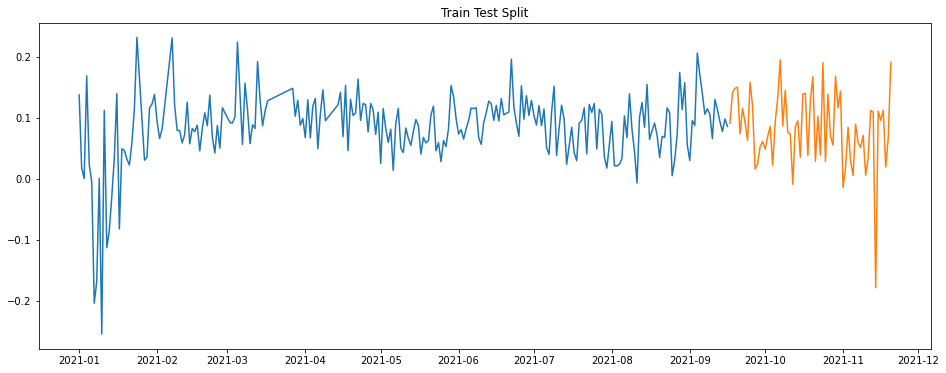

In [178]:
train = comp_ts_d[:cutoff]
test = comp_ts_d[cutoff:]
plt.figure(figsize=(16,6))
plt.plot(train)
plt.plot(test)
plt.title('Train Test Split');

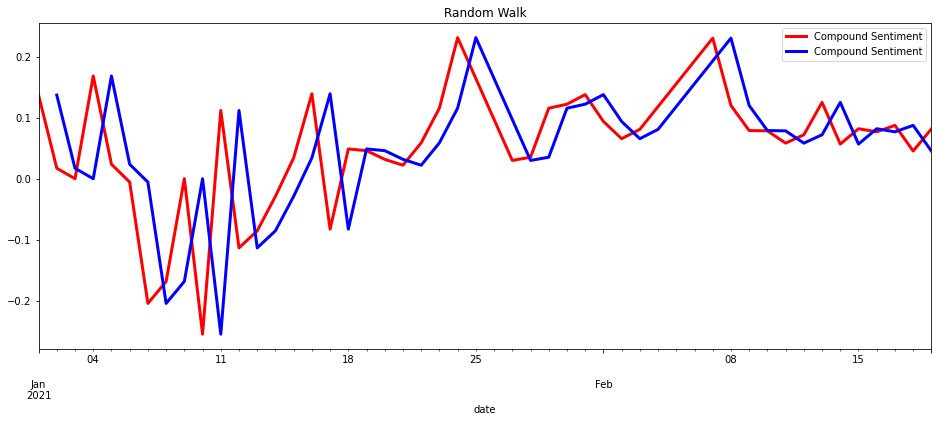

In [207]:
random_walk = train.shift(1)
fig, ax=plt.subplots(figsize=(16,6))
train[0:50].plot(ax=ax,color='red', label='original',linewidth=3.0)
random_walk[0:50].plot(ax=ax,color='blue', label='shifted',linewidth=3.0)
ax.set_title('Random Walk')
ax.legend();

In [199]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(train[1:], random_walk.dropna()))

0.06215720201401438

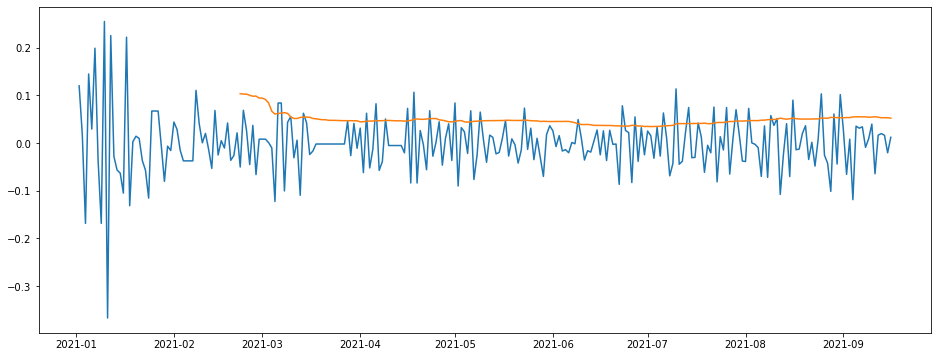

In [202]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(52).std());

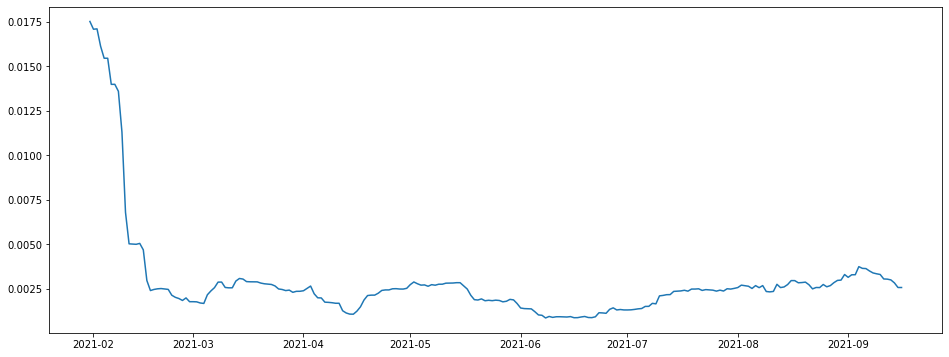

In [203]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(residuals.index, residuals.rolling(30).var());

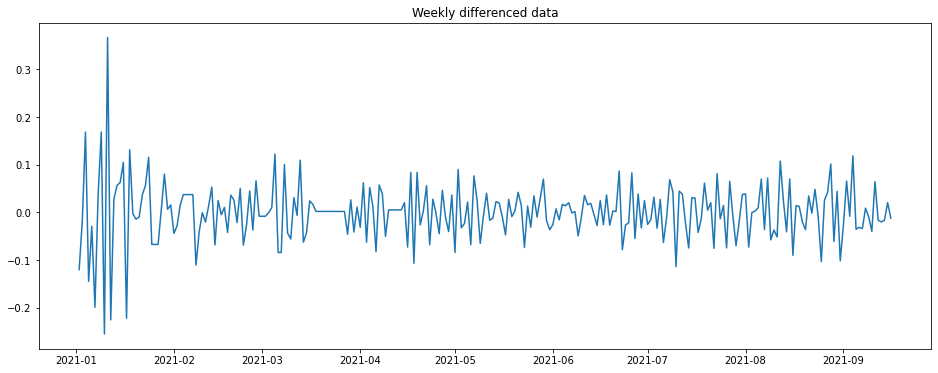

In [205]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(train.diff())
ax.set_title('Weekly differenced data');